In [41]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *
import dunestyle.matplotlib as dunestyle

plt.rcParams.update({
                     'figure.figsize': [8,6],
                     'xtick.labelsize': 'x-large',
                     'ytick.labelsize': 'x-large',
                     'figure.autolayout': True,
                     })

# plt.rcParams.update({'font.size': 23,
#                      'grid.linestyle': '--',
#                      'axes.grid': True,
#                      'figure.autolayout': True,
#                      'figure.figsize': [14,6]
#                      })

anatree:Anatree
mcstree:uproot.models.TTree.Model_TTree_v20
mcsangle:pl.DataFrame
dfana:pl.DataFrame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import uproot.models
import uproot.models.TTree

def get_dump(fname):

    # mcstree:uproot.models.TTree.Model_TTree_v20
    mcstree = uproot.open(fname)

    arr={}
    
    alldata:ak.Array
    alldata = mcstree.arrays()
    top = len(alldata)

    klist = ['run','subrun','event','isContained','trkpdg', 'E']
    for c in klist:
        a  = alldata[c][:top]
        arr[c] = a
    tangles = pd.DataFrame(arr)
    dfret = pl.from_pandas(tangles)
    dfret = dfret.with_columns(
        p = (pl.col("E")**2 - 0.1057**2).sqrt()
    )
    return dfret


mcs = get_dump('../../data/tracks_pdgcode_full.root:t1')

In [43]:
dfpdg = mcs.group_by(selection_events()).agg(
    pl.all().first()
).select(selection_events(['trkpdg','E', 'isContained']))

In [44]:
anatree = Anatree("", load_data=False)
anatree.read_parquet('../../data/parquet_anatree_modified_chi2_llhd_chi2_no_angle_correction/')

anatreeo = Anatree("", load_data=False)
anatreeo.read_parquet('../../data/parquet_anatree_original_reco2/')

Reading nu files... 33/33
Reading geant files... 33/33



Reading nu files... 32/32
Reading geant files... 32/32
Reading reco_tracks files... 32/32

Reading pfp files... 32/32


In [45]:
def select_numu_cc(df:pl.DataFrame):
    df = df.filter(
        (pl.col('nuPDG_truth').abs() == 14) & (pl.col('ccnc_truth')==0)
    ).with_columns(
        E = (pl.col('lep_mom_truth')**2 + 0.1057**2).sqrt(),
        p = pl.col('lep_mom_truth'),
        Echi2 = pl.when(pl.col("RecoLepEnNumu_mcs_chi2")>-1).then(pl.col("RecoLepEnNumu_mcs_chi2")).otherwise(0.1),
        Ellhd = pl.when(pl.col("RecoLepEnNumu_mcs_llhd")>-1).then(pl.col("RecoLepEnNumu_mcs_llhd")).otherwise(0.1),
        Erange = pl.col('RecoLepEnNumu'),
    ).with_columns(
        pchi2 = (pl.col('Echi2')**2  - 0.1057**2).sqrt(),
        pllhd = (pl.col('Ellhd')**2  - 0.1057**2).sqrt(),
        prange = (pl.col('Erange')**2  - 0.1057**2).sqrt(),
        Ereco = pl.when(pl.col('LongestTrackContNumu')==1).then(pl.col('Erange')).otherwise(
            pl.col('Ellhd')
        ),
        Ereco2 = pl.when(pl.col('LongestTrackContNumu')==1).then(pl.col('Erange')).otherwise(
            # pl.when(pl.col('Echi2')>2).then(pl.col('Echi2')).otherwise(pl.col('Ellhd'))
            pl.when(pl.col('Echi2')>2).then(pl.max_horizontal('Echi2','Ellhd')).otherwise(pl.col('Ellhd'))
        )
    )
    return df
dfnu = select_numu_cc(anatree.nu.collect())
dfnuo = select_numu_cc(anatreeo.nu.collect())

In [46]:
def adjust(df:pl.DataFrame):
    df = df.with_columns(
        isContained = pl.when(pl.col('Erange')==0).then(None).otherwise(
            pl.col('isContained')
        )
    ).filter(
        # ~pl.col('isContained').is_null(),
        pl.col('trkpdg').abs()==13,
    )
    return df
    
df = dfnu.join(dfpdg, on=selection_events(), how="inner")
dfo = dfnuo.join(dfpdg, on=selection_events(), how="inner")


df = adjust(df)
dfo = adjust(dfo)


In [125]:
def SetDUNELogoColors():
    """ Set the color cycler to use the subset of Okabe-Ito colors that overlap with the DUNE logo colors. """

    from cycler import cycler
    cyc = cycler(color=['#D55E00', '#56B4E9', '#E69F00', '#009E73'])
    plt.rc("axes", prop_cycle=cyc)
def resolution_plot(data_list, labels=None, true="E", reco="Ereco", legloc='best'):
    Ebins = np.logspace(-1,1,60)
    if not isinstance(data_list, list):
        data_list = [data_list]
    if isinstance(labels, list):
        assert(len(data_list) == len(labels))
    else:
        labels = [""] * len(data_list)
    
    SetDUNELogoColors()

    for data, label in zip(data_list, labels):
        data = data.filter(pl.col(reco)>0)
        bias = binned_statistic(data[true], data[reco]/data[true] - 1, bins=Ebins, statistic='mean').statistic
        # std = binned_statistic(data[true], data[reco]/data[true] - 1, bins=Ebins, statistic=manual_std).statistic
        std = binned_statistic(data[true], data[reco], bins=Ebins, statistic=manual_std).statistic
        recomean = binned_statistic(data[true], data[reco], bins=Ebins, statistic='mean').statistic
        std=std/recomean
        
        # plt.fill_between(0.5*(Ebins[:-1] + Ebins[1:]), bias - std/2, bias + std/2, alpha=0.5, label=fr'$\sigma(E_{{reco}})/E_{{reco}}$ {label}')
        plt.fill_between(0.5*(Ebins[:-1] + Ebins[1:]), bias - std/2, bias + std/2, alpha=0.5, label=fr'Relative resolution {label}')
        plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), bias, label=f'Relative bias')
    plt.xscale('log')
    plt.xlabel(r'True Muon Energy [GeV]')
    plt.ylabel(r"Energy reconstruction")
    plt.legend(loc=legloc)
    plt.tight_layout()

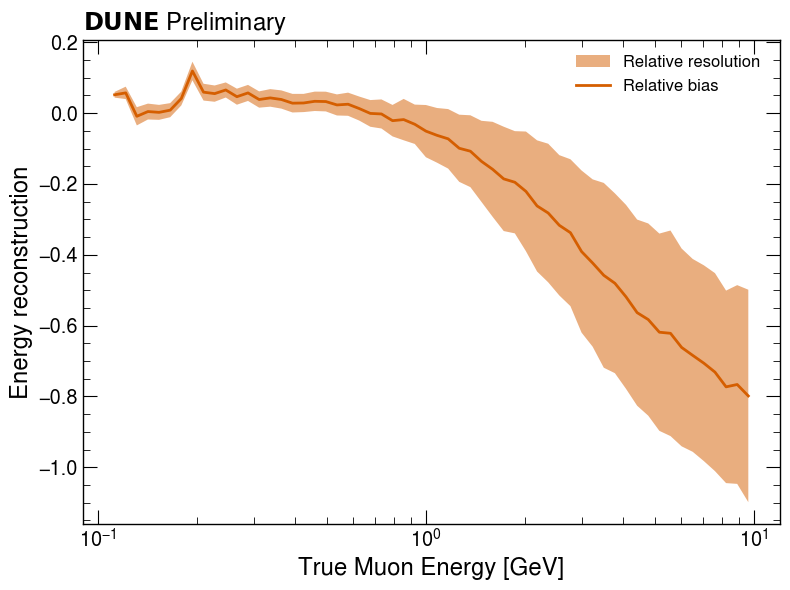

In [132]:
plt.figure(figsize=(8,6))
# resolution_plot(df, labels=['CSDA - Chi2'], reco='RecoLepEnNumu')
resolution_plot(df, labels=[''], legloc='best')
dunestyle.Preliminary(x=0, y=1.02, ax=plt.gca(), fontsize="xx-large")
plt.savefig('./pdf/ereco_possibilites_new.pdf', dpi=200)

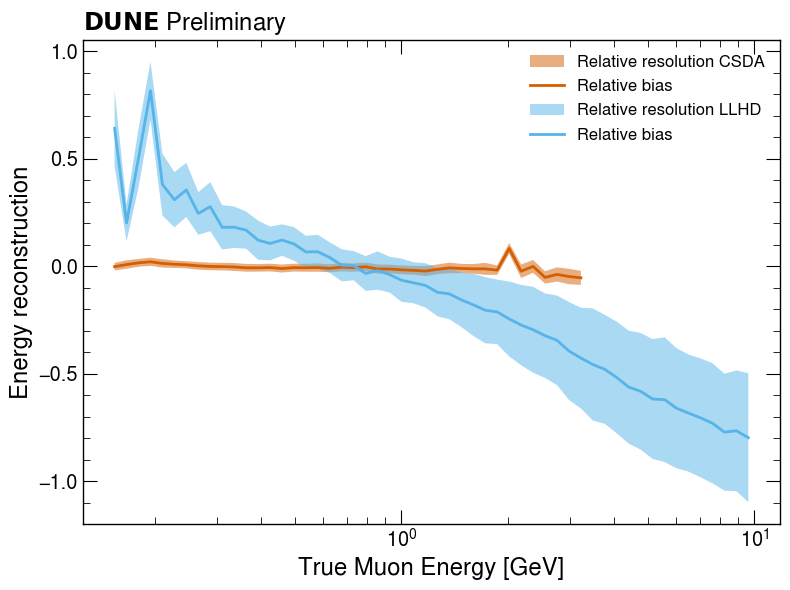

In [138]:
plt.figure(figsize=(8,6))
# resolution_plot(df, labels=['CSDA - Chi2'], reco='RecoLepEnNumu')
resolution_plot(df.filter(pl.col('E')>0.15, pl.col('isContained')), reco='Erange', labels=['CSDA'], legloc='best')
resolution_plot(df.filter(pl.col('E')>0.15,~pl.col('isContained')), reco='Ellhd', labels=['LLHD'], legloc='best')
# resolution_plot(df.filter(pl.col('E')>0.15,~pl.col('isContained')), reco='Echi2', labels=['Chi2'], legloc='best')
dunestyle.Preliminary(x=0, y=1.02, ax=plt.gca(), fontsize="xx-large")
plt.savefig('./pdf/ereco_methods_new.pdf', dpi=200)